# AutoEncoders on Image Data
For Fashion MNST dataset, images are 28x28 and dimensions of 784, which is basically 784 features.

## This is a good way to use Autoencoder.
What we gonna do is

- pass the image through Autoencoder
- Then have the Autoencoder attempt to recreat the image as the output.
Bascially Autoencoder will attempt to learn what pixels are important when encoded it down to smaller hidden layers, then use those to recreate when decoding.

However this is not very useful though.

## What useful is removing Noises.
Noises are real world problem. So using Autoencoder to remove nosies will be a Great way to use. The same logic is applied.

pass the image through Autoencoder
Then hopefully Autoencoder will learn what features are important in reconstruct the correct images without the noises.
We will create both Autoencoders.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

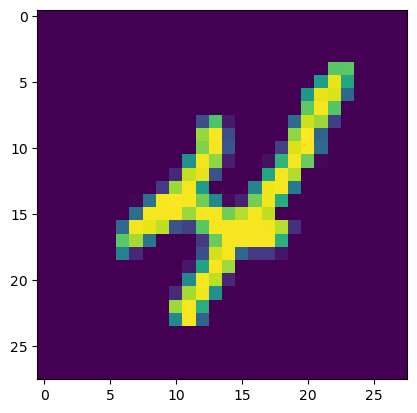

In [4]:
plt.imshow(x_train[9]);

## Scaled the data

In [5]:
x_train[0].shape

(28, 28)

## <a>Why do we divide by 255?
Since 255 is the maximum value, dividing by 255 expresses a 0-1 representation. Each channel (Red, Green, and Blue are each channels) is 8 bits, so they are each limited to 256, in this case 255 since 0 is included.

In [6]:
x_train[0].max()

255

In [7]:
x_train = x_train/255
x_test = x_test/255

---------
------
# <a> Part 1. Build AutoEncoder

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.optimizers import SGD

In [9]:
x_train[0].shape

(28, 28)

In [10]:
28*28

784

In [11]:
784/2 # reduced by halp

392.0

## <a> Build Encoder

In [12]:
encoder = Sequential() 

encoder.add(Flatten(input_shape =[28,28])) # flatten this from (28, 28) to 784

encoder.add(Dense(400, activation='relu')) # reduce to halp => 784 to 400
encoder.add(Dense(200, activation='relu')) # reduce to halp => 400 to 200
encoder.add(Dense(100, activation='relu')) # reduce to halp => 200 to 100
encoder.add(Dense(50, activation='relu')) # reduce to halp => 100 to 50
encoder.add(Dense(25, activation='relu')) # reduce to halp => 50 to 25 (reduced to 3% of original dimensions)

## <a>Building Decoder
- Now we are basically reversing what encoder has done
    
- when we decode, we need to skip the Central layer (which is the last layer of encoder; in our case 25 neurons one)
    
## <a>We need to use sigmoid in second to last layer
    
- we are using Binarycrossentropy loss at the end of our autoencoder, checking whether the output image (after going through all encoders) matched the original image.
    
## <a>Why we use Binarycrossentropy for loss?
    
- Autoencoder doesn't care how many types of distinct numbers are or classes.
    
- All it cares it the image I am producing at the output going to match the image that is originally put as input.

# <a> Build Decoder

In [13]:
decoder = Sequential()

decoder.add(Dense(50, input_shape=[25], activation='relu')) #  here we use input_shape as 25 which is the last layer of our encoder
decoder.add(Dense(100, activation='relu'))
decoder.add(Dense(200, activation='relu'))
decoder.add(Dense(400, activation='relu'))
decoder.add(Dense(28*28, activation='sigmoid')) #   # activation needs to be sigmoid because we are using binarycrossentropy loss

decoder.add(Reshape([28, 28]))

# <a> Combining Encoder + Decoder as AutoDecoder

In [14]:
autoencoder = Sequential([encoder, decoder])

autoencoder.compile(loss='binary_crossentropy', 
                    optimizer= SGD(learning_rate=1.5), 
                    metrics =['accuracy'])

# <a> Training AutoEncoder
    

Take note that AutoEncoder is semi-supervised learning. It is not actually trying to predict the classification or anything. All it doing is trying to learn the important features and reduce the dimensionality.

So when giving input and ouput for fitting is different from supervised learning ones.

In [15]:
x_train.shape

(60000, 28, 28)

In [16]:
autoencoder.fit(x_train, x_train, 
                epochs = 5, 
                validation_data = (x_test, x_test))

Epoch 1/5
1875/1875 [==============================] - 41s 18ms/step - loss: 0.2547 - accuracy: 0.0817 - val_loss: 0.2327 - val_accuracy: 0.0952
Epoch 2/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.1960 - accuracy: 0.1506 - val_loss: 0.1749 - val_accuracy: 0.1734
Epoch 3/5
1875/1875 [==============================] - 38s 20ms/step - loss: 0.1637 - accuracy: 0.1919 - val_loss: 0.1517 - val_accuracy: 0.2072
Epoch 4/5
1875/1875 [==============================] - 39s 21ms/step - loss: 0.1501 - accuracy: 0.2098 - val_loss: 0.1447 - val_accuracy: 0.2089
Epoch 5/5
1875/1875 [==============================] - 40s 21ms/step - loss: 0.1432 - accuracy: 0.2208 - val_loss: 0.1390 - val_accuracy: 0.2274


----------
----------

# <a> Check how images look like after passing through AutoEncoder
We will pass 10 images that AutoEncoder **DOES NOT TRAINED ON.**

Let's see how autoencoder predicts(attempts to reconstruct after reducing the dimensionality) those images.

In [17]:
passed_image = autoencoder.predict(x_test[:10])

1/1 [==============================] - 0s 388ms/step


image original


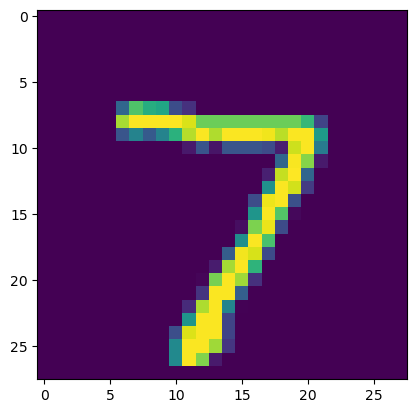

after autoencoder


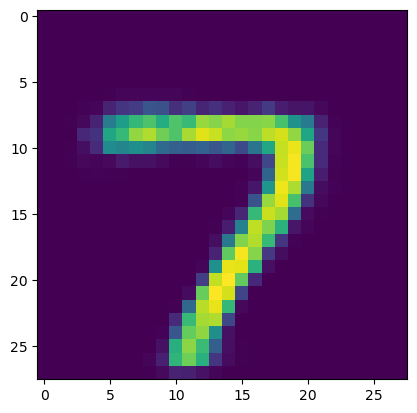

In [18]:
n = 0
print('image original')
plt.imshow(x_test[n])
plt.show()

print('after autoencoder')
plt.imshow(passed_image[n])
plt.show();

-------------
-------------
# <a>PART II: AutoEncoders for Denoising Images
## Demo for adding nosies
- There are many way to add noise into images. For the sake of convinence, we will use GaussianNoise
    
- The larger value we choose for std parameter, the more noise will be added.

In [19]:
from tensorflow.keras.layers import GaussianNoise

In [20]:
sample = GaussianNoise(0.2) # the higher the std value, the nosier

In [21]:
noise = sample(x_test[:10], training=True) # training on the first 10 images of Test dataset

Original image


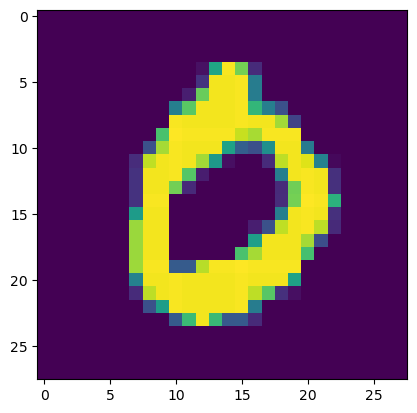

Using GaussianNoise


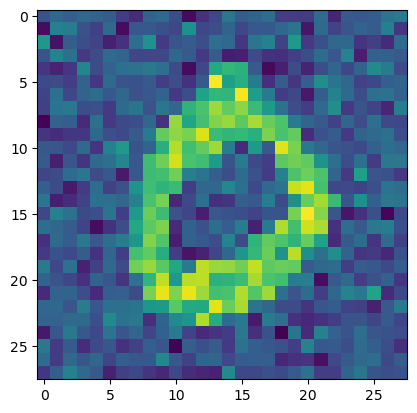

In [22]:
n = 3

print('Original image')
plt.imshow(x_test[n])
plt.show()

print('Using GaussianNoise')
plt.imshow(noise[n])
plt.show();

## Build noise removal autoencoder

In [23]:
import tensorflow as tf

In [24]:
tf.random.set_seed(101)

##  <a> Encoder

In [25]:
encoder = Sequential()

encoder.add(Flatten(input_shape=[28,28]))

encoder.add(GaussianNoise(0.2)) # Add noise to images before going through autoencoder

encoder.add(Dense(400, activation='relu'))
encoder.add(Dense(200, activation='relu'))
encoder.add(Dense(100, activation='relu'))
encoder.add(Dense(50, activation='relu'))
encoder.add(Dense(25, activation='relu'))

## <a> Decoder

In [26]:
decoder = Sequential()

decoder.add(Dense(50, input_shape=[25], activation='relu'))
decoder.add(Dense(100, activation='relu'))
decoder.add(Dense(200, activation='relu'))
decoder.add(Dense(400, activation='relu'))
decoder.add(Dense(784, activation='sigmoid'))

decoder.add(Reshape([28,28]))

# <a> Combine Encoder and Decoder as Noise Remover AutoEncoder

In [27]:
noise_remover = Sequential([encoder, decoder])

In [28]:
# compile 
noise_remover.compile(loss='binary_crossentropy', 
                      optimizer=SGD(learning_rate=1.5), 
                      metrics=['accuracy'])

## <a> Train Noise Remover AutoEncoder

In [29]:
noise_remover.fit(x_train, x_train, 
                  epochs = 8, 
                  validation_data=(x_test, x_test))

Epoch 1/8
1875/1875 [==============================] - 62s 22ms/step - loss: 0.2548 - accuracy: 0.0796 - val_loss: 0.2184 - val_accuracy: 0.1147
Epoch 2/8
1875/1875 [==============================] - 42s 22ms/step - loss: 0.2049 - accuracy: 0.1347 - val_loss: 0.1808 - val_accuracy: 0.1649
Epoch 3/8
1875/1875 [==============================] - 44s 23ms/step - loss: 0.1702 - accuracy: 0.1813 - val_loss: 0.1535 - val_accuracy: 0.1985
Epoch 4/8
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1533 - accuracy: 0.2039 - val_loss: 0.1453 - val_accuracy: 0.2116
Epoch 5/8
1875/1875 [==============================] - 43s 23ms/step - loss: 0.1459 - accuracy: 0.2162 - val_loss: 0.1400 - val_accuracy: 0.2194
Epoch 6/8
1875/1875 [==============================] - 44s 23ms/step - loss: 0.1399 - accuracy: 0.2264 - val_loss: 0.1371 - val_accuracy: 0.2320
Epoch 7/8
1875/1875 [==============================] - 49s 26ms/step - loss: 0.1358 - accuracy: 0.2320 - val_loss: 0.1349 - val_ac

# <a>Check how Noisey Images are handled

In [30]:
ten_noise_image = sample(x_test[:10], training =True)

In [31]:
denoise = noise_remover(ten_noise_image)

Original Image


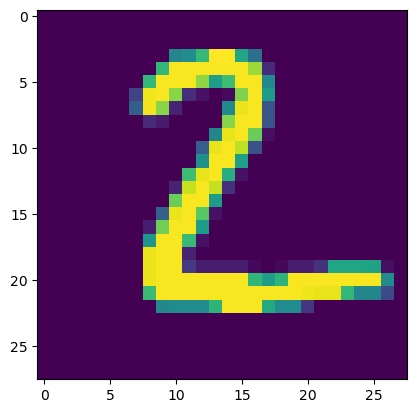

Noise Image


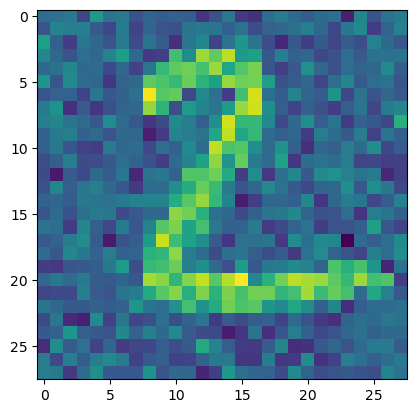

After Noise Removal from AutoEncoder


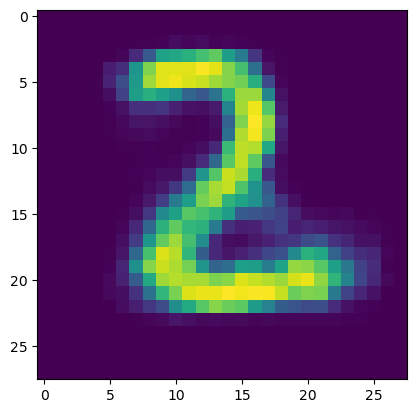

In [32]:
n = 1

print('Original Image')
plt.imshow(x_test[n])
plt.show()

print('Noise Image')
plt.imshow(noise[n])
plt.show()

print('After Noise Removal from AutoEncoder')
plt.imshow(denoise[n])
plt.show()
